# 叠加图

本节组合前面三节内容，介绍如何使用 cedarkit-maps 绘制 500 hPa 位势高度 + 850 hPa 风速叠加图。

首先导入需要使用的包。包括：

- 数据结构：numpy, pandas
- cedarkit 工具套件
    - 数据准备：reki
        - 数据查找函数： `find_local_file`
        - GRIB2文件要素加载函数：`load_field_from_file`
    - 气象可视化：cedarkit.maps
        - 绘图板：`Panel`
        - 底图布局：`EastAsiaMapDomain`
        - 绘图样式：`ContourStyle`, `ContourLabelStyle`, `BarbStyle`
        - 颜色表加载函数：`get_ncl_colormap`

In [1]:
import numpy as np
import pandas as pd

from reki.data_finder import find_local_file
from reki.format.grib.eccodes import load_field_from_file

from cedarkit.maps.style import ContourStyle, ContourLabelStyle, BarbStyle
from cedarkit.maps.chart import Panel
from cedarkit.maps.domains import EastAsiaMapDomain
from cedarkit.maps.colormap import get_ncl_colormap

设置绘图的数据参数，使用 CMA-GFS 2024 年 4 月 1 日 00 时次 024 数据。

In [2]:
system_name = "CMA-GFS"
data_type = "cma_gfs_gmf/grib2/orig"
start_time = pd.to_datetime("2024-04-01 00:00:00")
forecast_time = pd.to_timedelta("24h")

## 加载数据

获取 GRIB2 数据路径

In [3]:
file_path = find_local_file(
    data_type,
    start_time=start_time,
    forecast_time=forecast_time,
)
file_path

PosixPath('/g3/COMMONDATA/OPER/CEMC/GFS_GMF/Prod-grib/2024040100/ORIG/gmf.gra.2024040100024.grb2')

加载 500 hPa 位势高度场。位势高度在 ecCodes 的内置要素名为 `gh`

In [4]:
h_500_field = load_field_from_file(
    file_path,
    parameter="gh",
    level_type="pl",
    level=500
) / 10.0
h_500_field

<xarray.DataArray 'gh' (latitude: 1440, longitude: 2880)> Size: 33MB
array([[524.26007813, 524.26007813, 524.26007813, ..., 524.26007813,
        524.26007813, 524.26007813],
       [524.47007813, 524.47007813, 524.47007813, ..., 524.47007813,
        524.47007813, 524.47007813],
       [524.65007813, 524.65007813, 524.65007813, ..., 524.65007813,
        524.65007813, 524.65007813],
       ...,
       [488.70007813, 488.70007813, 488.70007813, ..., 488.70007813,
        488.70007813, 488.70007813],
       [488.63007813, 488.63007813, 488.63007813, ..., 488.63007813,
        488.63007813, 488.63007813],
       [488.58007812, 488.58007812, 488.58007812, ..., 488.58007812,
        488.58007812, 488.58007812]])
Coordinates:
    time        datetime64[ns] 8B 2024-04-01
    step        timedelta64[ns] 8B 1 days
    valid_time  datetime64[ns] 8B 2024-04-02
    pl          float64 8B 500.0
  * latitude    (latitude) float64 12kB 89.94 89.81 89.69 ... -89.81 -89.94
  * longitude   (longitude) float64 23kB 0.0 0.125 0.25 ... 359.6 359.8 359.9

加载 850 hPa 风场。风场在 ecCodes 的内置要素名为 `u` 和 `v`

In [5]:
u_850_field = load_field_from_file(
    file_path,
    parameter="u",
    level_type="pl",
    level=850
)
v_850_field = load_field_from_file(
    file_path,
    parameter="v",
    level_type="pl",
    level=850
)
u_850_field

<xarray.DataArray 'u' (latitude: 1440, longitude: 2880)> Size: 33MB
array([[ 4.8503418,  4.8703418,  4.8903418, ...,  4.7703418,  4.7803418,
         4.8103418],
       [ 4.6903418,  4.7103418,  4.7303418, ...,  4.6403418,  4.6603418,
         4.6803418],
       [ 4.5903418,  4.6103418,  4.6203418, ...,  4.5403418,  4.5503418,
         4.5703418],
       ...,
       [-0.7196582, -0.6996582, -0.6896582, ..., -0.7596582, -0.7396582,
        -0.7296582],
       [-0.2396582, -0.2296582, -0.2096582, ..., -0.2796582, -0.2696582,
        -0.2596582],
       [-0.5796582, -0.5696582, -0.5596582, ..., -0.6096582, -0.6096582,
        -0.5896582]])
Coordinates:
    time        datetime64[ns] 8B 2024-04-01
    step        timedelta64[ns] 8B 1 days
    valid_time  datetime64[ns] 8B 2024-04-02
    pl          float64 8B 850.0
  * latitude    (latitude) float64 12kB 89.94 89.81 89.69 ... -89.81 -89.94
  * longitude   (longitude) float64 23kB 0.0 0.125 0.25 ... 359.6 359.8 359.9
Attributes: (12/17)
    GRIB_edition:             2
    GRIB_centre:              babj
    GRIB_subCentre:           0
    GRIB_tablesVersion:       4
    GRIB_localTablesVersion:  0
    GRIB_dataType:            fc
    ...                       ...
    GRIB_stepType:            instant
    GRIB_stepUnits:           1
    GRIB_stepRange:           24
    GRIB_endStep:             24
    GRIB_count:               149
    long_name:                discipline=0 parmcat=2 parm=2

计算得到风速场

In [6]:
wind_speed_850_field = np.sqrt(u_850_field ** 2 + v_850_field ** 2)
wind_speed_850_field

<xarray.DataArray (latitude: 1440, longitude: 2880)> Size: 33MB
array([[10.05180549, 10.05272224, 10.04495258, ..., 10.03983504,
        10.03579651, 10.041342  ],
       [ 9.25990743,  9.26144246,  9.25443484, ...,  9.26928709,
         9.26202629,  9.2634746 ],
       [ 8.89937259,  8.90114955,  8.88924093, ...,  8.90807667,
         8.9045805 ,  8.89765148],
       ...,
       [ 5.73121708,  5.73866535,  5.74738235, ...,  5.74628915,
         5.73376278,  5.73248135],
       [ 5.26131566,  5.27086012,  5.27002657, ...,  5.28326124,
         5.26276752,  5.25227681],
       [ 4.29514855,  4.29381042,  4.29249517, ...,  4.29930001,
         4.2894013 ,  4.28660439]])
Coordinates:
    time        datetime64[ns] 8B 2024-04-01
    step        timedelta64[ns] 8B 1 days
    valid_time  datetime64[ns] 8B 2024-04-02
    pl          float64 8B 850.0
  * latitude    (latitude) float64 12kB 89.94 89.81 89.69 ... -89.81 -89.94
  * longitude   (longitude) float64 23kB 0.0 0.125 0.25 ... 359.6 359.8 359.9

## 配置

为 500 hPa 位势高度场定义等值线样式

In [7]:
h_contour_lev = np.linspace(500, 588, endpoint=True, num=23)
h_contour_colos = "blue"
h_linewidths = np.where(h_contour_lev == 588, 1.4, 0.7)
hgt_style = ContourStyle(
    levels=h_contour_lev,
    colors="blue",
    linewidths=h_linewidths,
    label=True,
    label_style=ContourLabelStyle(
        colors="black",
        fontsize=8,
    )
)

为 850 hPa 风速定义填充图样式

In [8]:
wind_speed_contour_lev = np.arange(8, 26, 2)

color_index = np.arange(90, 236, 15) - 2
color_index[0] = -1
wind_speed_color_map = get_ncl_colormap(
    "rainbow+white+gray", index=color_index
)

wind_speed_style = ContourStyle(
    colors=wind_speed_color_map,
    levels=wind_speed_contour_lev,
    fill=True,
)

为 850 hPa 风场定义风场图样式

In [9]:
wind_barb_style = BarbStyle(
    barbcolor="red",
    flagcolor="red",
    linewidth=0.3,
)

## 绘制

创建中国区域底图布局

In [10]:
domain = EastAsiaMapDomain()

绘制叠加图，设置标题和颜色条。

多次调用 `Panel.plot()` 方法实现图形的叠加绘制。

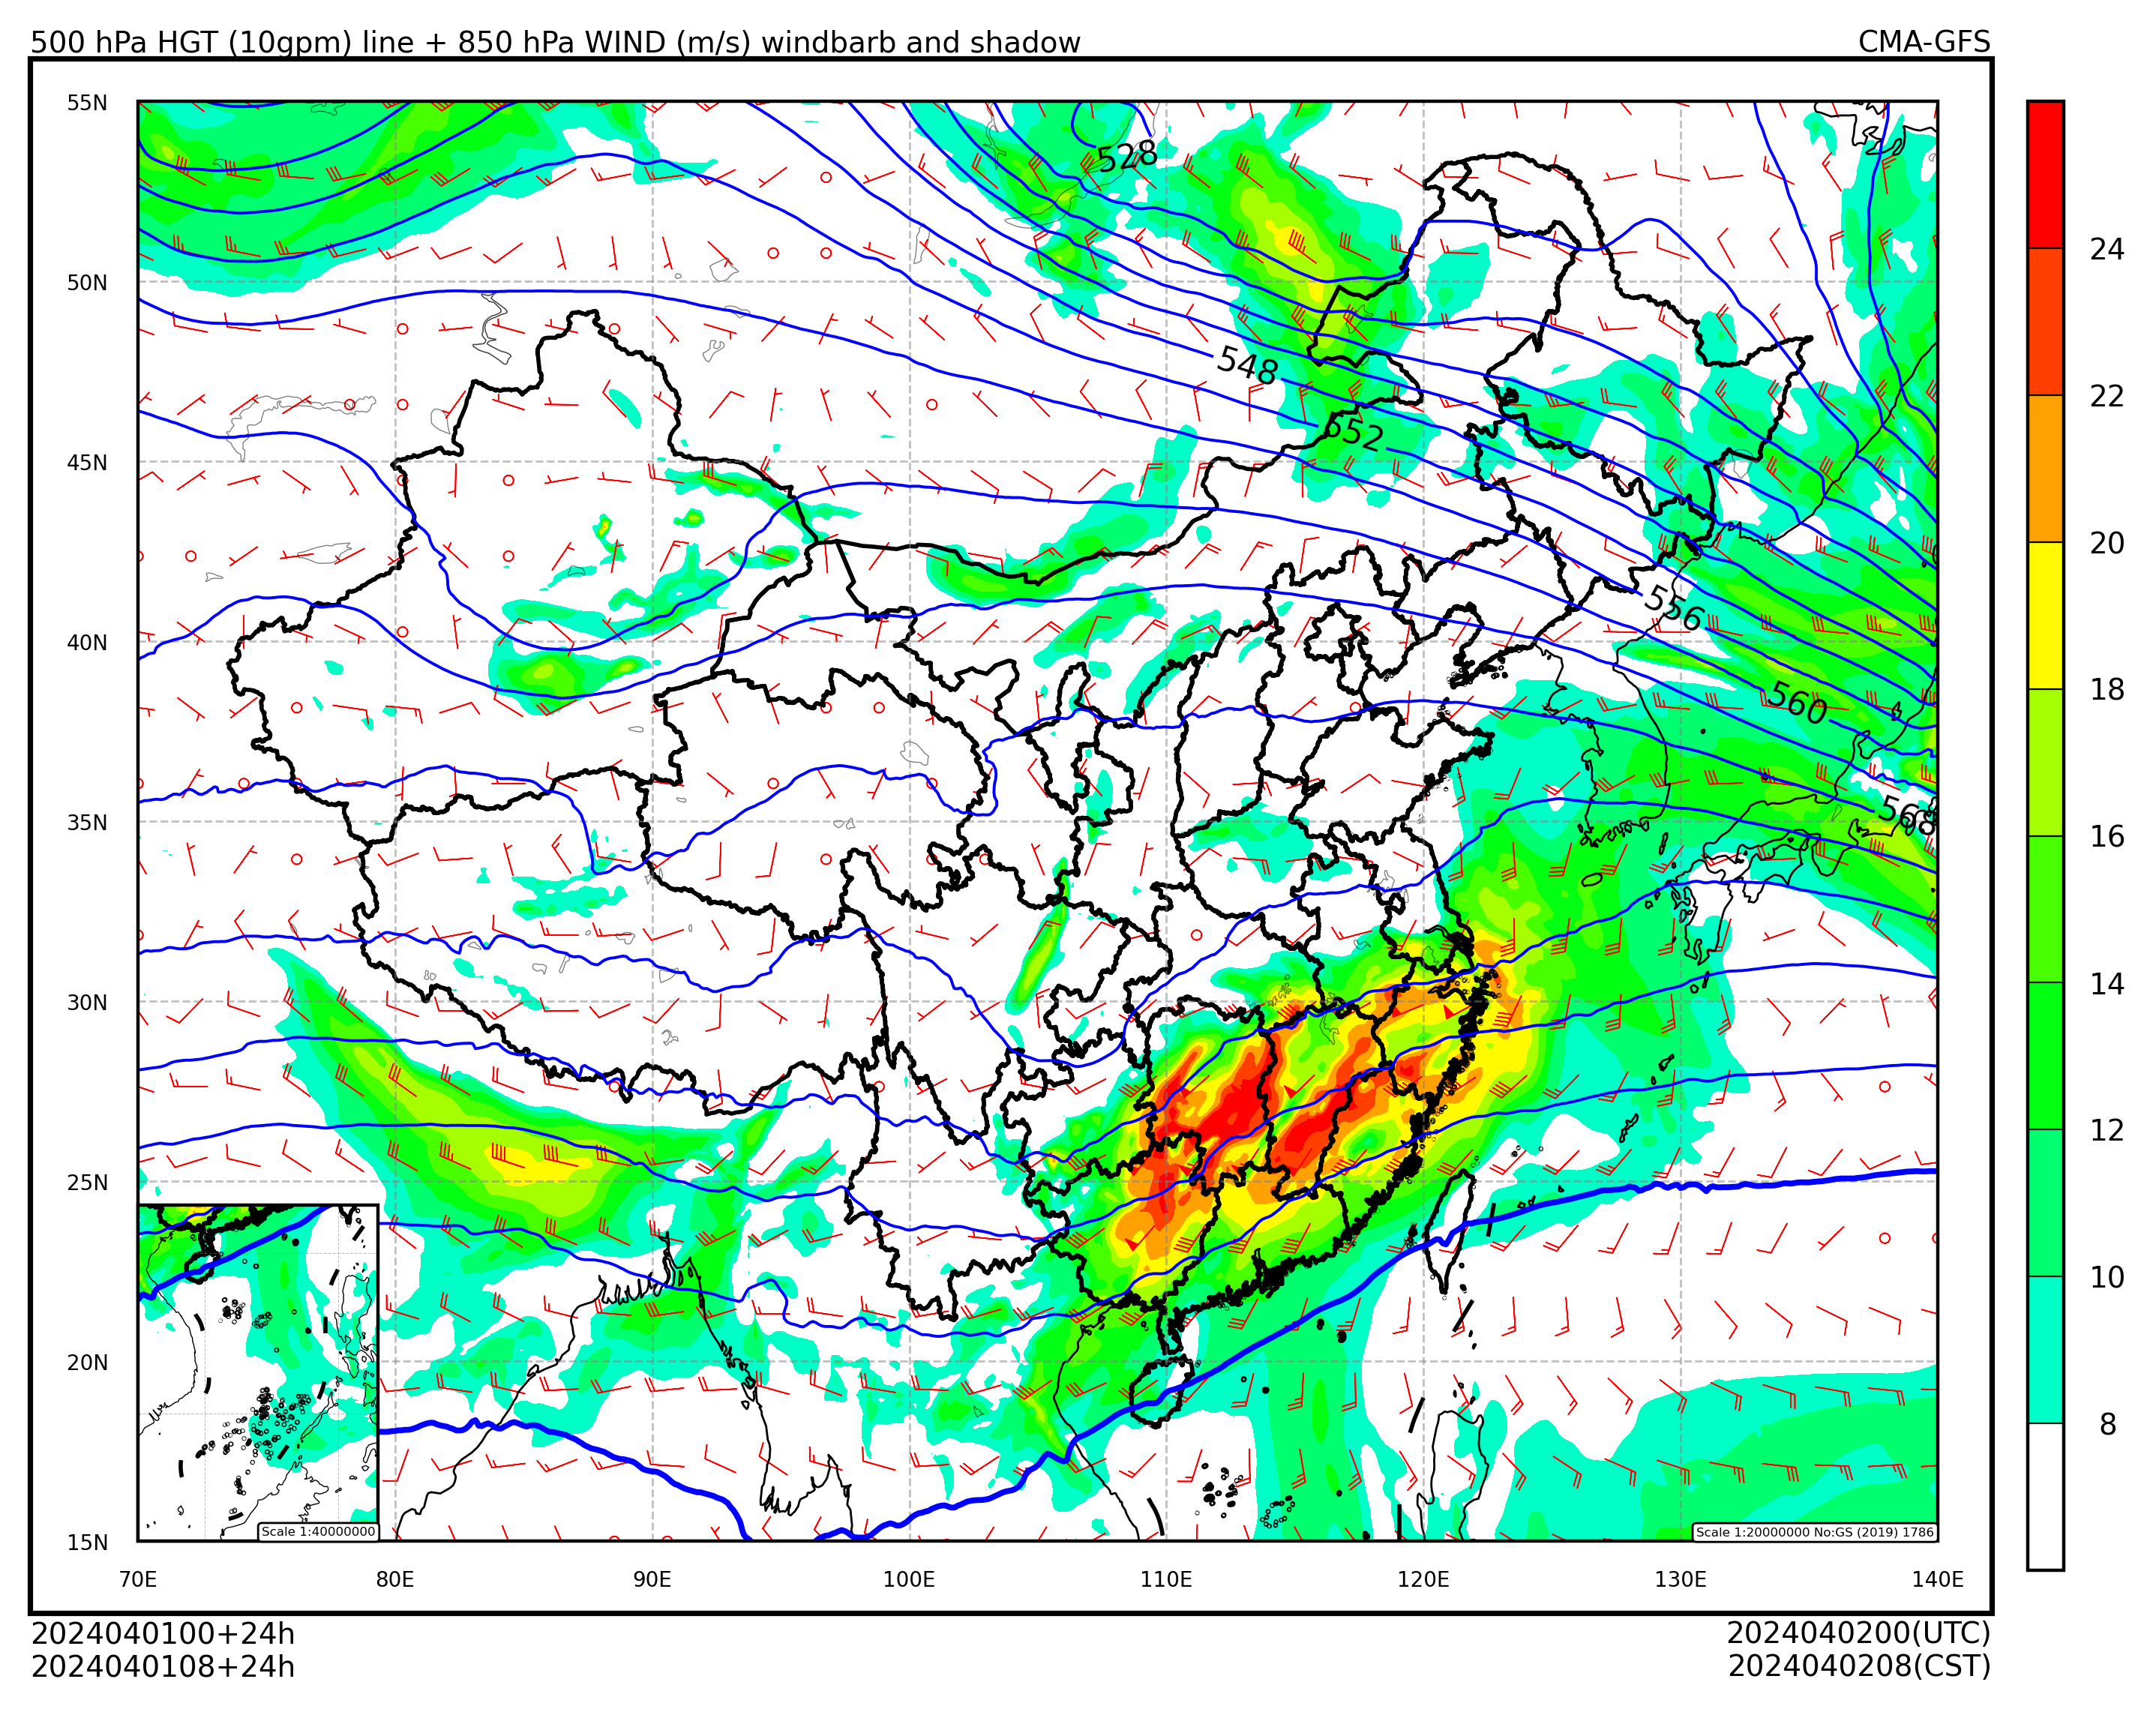

In [11]:
panel = Panel(domain=domain)
panel.plot(h_500_field, style=hgt_style)
panel.plot(wind_speed_850_field, style=wind_speed_style)
panel.plot([[u_850_field[::14, ::14], v_850_field[::14, ::14]]], style=wind_barb_style, layer=[0])

domain.set_title(
    panel=panel,
    graph_name="500 hPa HGT (10gpm) line + 850 hPa WIND (m/s) windbarb and shadow",
    system_name=system_name,
    start_time=start_time,
    forecast_time=forecast_time,
)
domain.add_colorbar(panel=panel, style=wind_speed_style)
panel.show()